# Unsupervised Anomaly Detection in Amazon SageMaker (IP address detection)

Amazon SageMaker IP insights ingests historical data as (entity, IPv4 Address) pairs and learns the IP usage patterns of each entity. When queried with an (entity, IPv4 Address) event, an Amazon SageMaker IP Insights model returns a score that infers how anomalous the pattern of the event is. For example, when a user attempts to log in from an IP address, if the IP Insights score is high enough, a web login server might decide to trigger a multi-factor authentication system. In more advanced solutions, you can feed the IP Insights score into another machine learning model.

In this notebook, we use the Amazon SageMaker IP Insights algorithm to train a model on synthetic data. We then use this model to perform inference on the data and show how to discover suspicious IP addresses. After running this notebook, you should be able to:

- obtain, transform, and store data for use in Amazon SageMaker,
- create an AWS SageMaker training job to produce an IP Insights model,
- use the model to perform inference with an Amazon SageMaker endpoint.
If you would like to know more, please check out the SageMaker IP Inisghts Documentation.

**Training and Validation**

The Amazon SageMaker IP Insights algorithm supports training and validation data channels. It uses the optional validation channel to compute an area-under-curve (AUC) score on a predefined negative sampling strategy. The AUC metric validates how well the model discriminates between positive and negative samples. Training and validation data content types need to be in text/csv format. The first column of the CSV data is an opaque string that provides a unique identifier for the entity. The second column is an IPv4 address in decimal-dot notation. IP Insights currently supports only File mode. For more information and some examples, see IP Insights Training Data Formats.

**Inference**

For inference, IP Insights supports text/csv, application/json, and application/jsonlines data content types. For more information about the common data formats for inference provided by Amazon SageMaker, see Common Data Formats for Inference. IP Insights inference returns output formatted as either application/json or application/jsonlines. Each record in the output data contains the corresponding dot_product (or compatibility score) for each input data point. For more information and some examples, see IP Insights Inference Data Formats.

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
import tqdm
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv
from datetime import datetime
import pytz

import cv2

import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [2]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'ip-insights'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001E5B61FF448>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : ip-insights
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image = get_image_uri(region, 'ipinsights', 'latest')
print(image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


174872318107.dkr.ecr.us-west-2.amazonaws.com/ipinsights:latest


### 2. Load Data

In [4]:
# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://sagemaker-us-west-2-570447867175/ip-insights


##### We will generate sample web-traffic logs. We mock up a toy website example and simulate users logging into the website from mobile devices

SageMaker Team has provided a Helper function to generate random IP addresses. Please refer to "Generate_data.py" python file

In [5]:
from generate_data import generate_dataset

# We simulate traffic for 10,000 users. This should yield about 3 million log lines (~700 MB). 
NUM_USERS = 10000
log_file = 'ipinsights_web_traffic.log'
generate_dataset(NUM_USERS, log_file)

Loaded ASN List: 827696 ASNs.
Starting User Activity Simulation
Finished simulating web activity for 10000 users.


##### Prepare the dataset
Now that we have our logs, we need to transform them into a format that IP Insights can use. As we mentioned above, we need to:

1. Choose the resource which we want to analyze users' history for
2. Extract our users' usage history of IP addresses
3. In addition, we want to separate our dataset into a training and test set. This will allow us to check for overfitting by evaluating our model on 'unseen' login events.

For the rest of the notebook, we assume that the Apache Access Logs are in the Common Log Format as defined by the Apache documentation. We start with reading the logs into a Pandas DataFrame for easy data exploration and pre-processing.

### 3. Data Pre-Processing

In [18]:
df = pd.read_csv(
    log_file,
    sep=" ",
    na_values='-',
    header=None,
    names=['ip_address','rcf_id','user','timestamp','time_zone','request', 'status', 'size', 'referer', 'user_agent']
)
df.head()

,ip_address,rcf_id,user,timestamp,time_zone,request,status,size,referer,user_agent
0,69.55.235.87,NaN,user_63,[12/Nov/2018:12:05:07,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,69.57.9.174,NaN,user_63,[12/Nov/2018:13:20:30,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,69.57.11.177,NaN,user_63,[08/Nov/2018:13:43:03,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,69.56.56.126,NaN,user_63,[05/Nov/2018:07:16:20,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,69.57.109.29,NaN,user_63,[04/Nov/2018:14:57:55,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


In [19]:
df.shape

(3167344, 10)

In [20]:
# Convert time stamps to DateTime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], format='[%d/%b/%Y:%H:%M:%S')

# Check if they are all in the same timezone
num_time_zones = len(df['time_zone'].unique())
num_time_zones

1

##### If there is more than one time_zone in your dataset, then we parse the timezone offset and update the corresponding datetime object.

In [21]:
def apply_timezone(row):
    tz = row[1]
    tz_offset = int(tz[:3]) * 60   # Hour offset
    tz_offset += int(tz[3:5])      # Minutes offset
    return row[0].replace(tzinfo=pytz.FixedOffset(tz_offset))

if num_time_zones > 1:
    df['timestamp'] = df[['timestamp','time_zone']].apply(apply_timezone, axis=1)

##### Select Resource
Our goal is to train an IP Insights algorithm to analyze the history of user logins such that we can predict how suspicious a login event is.

In our simulated web server, the server logs a GET request to the /login_success page everytime a user successfully logs in. We filter our Apache logs for GET requests for /login_success. We also filter for requests that have a status_code == 200, to ensure that the page request was well formed.

Note: every web server handles logins differently. For your dataset, determine which resource you will need to be analyzing to correctly frame this problem. Depending on your usecase, you may need to do more data exploration and preprocessing.

In [22]:
df = df[(df['request'].str.startswith('GET /login_success')) & (df['status'] == 200)]

##### Extract Users and IP address
This Algorithm takes in a CSV file with two columns: an entity (username) ID string and the IPv4 address in decimal-dot notation. Fortunately, the Apache Web Server Access Logs output IP addresses and authentcated usernames in their own columns.

Note: Each website handles user authentication differently. If the Access Log does not output an authenticated user, you could explore the website's query strings or work with your website developers on another solution.

In [23]:
df = df[['user', 'ip_address', 'timestamp']]

##### Create training and test dataset
For any timeseries ML problem, we want to use out-of-time testing. Instead of randomly sampling our dataset, we split our dataset into two contiguous time windows. The first window is the training set, and the second is the test set.

In [24]:
df['timestamp'].describe()

count                 3167344
unique                 841691
top       2018-11-13 05:50:21
freq                       16
first     2018-11-04 00:00:01
last      2018-11-14 00:00:00
Name: timestamp, dtype: object

We have login events for 10 days. Let's take the first week (7 days) of data as training and then use the last 3 days for the test set.

In [25]:
time_partition = datetime(2018, 11, 11, tzinfo=pytz.FixedOffset(0)) if num_time_zones > 1 else datetime(2018, 11, 11)

train_df = df[df['timestamp'] <= time_partition]
test_df = df[df['timestamp'] > time_partition]

Now that we have our training dataset, we shuffle it.

Shuffling improves the model's performance since SageMaker IP Insights uses stochastic gradient descent. This ensures that login events for the same user are less likely to occur in the same mini batch. This allows the model to improve its performance in between predictions of the same user, which will improve training convergence.

In [26]:
# Shuffle train data 
train_df = train_df.sample(frac=1)
train_df.head()

,user,ip_address,timestamp
2689795,user_8651,113.21.207.56,2018-11-08 08:53:39
2302139,user_7396,50.115.220.217,2018-11-07 05:17:14
1573917,user_5200,66.237.49.103,2018-11-04 09:33:53
1376593,user_4519,187.58.178.207,2018-11-08 18:42:04
1378182,user_4523,104.117.182.49,2018-11-05 00:48:52


### 4. Upload data to S3 Bucket
We will be doing local inference, therefore we don't need to upload our test dataset

In [27]:
train_data = train_df.to_csv(index=False, header=False, columns=['user', 'ip_address'])

In [28]:
# Upload data to S3 key
train_data_file = 'train.csv'
key = os.path.join(prefix, 'train', train_data_file)
s3_train_data = 's3://{}/{}'.format(bucket, key)

print('Uploading data to: {}'.format(s3_train_data))
boto3.resource('s3').Bucket(bucket).Object(key).put(Body=train_data)

# Configure SageMaker IP Insights Input Channels
input_data = {
    'train': sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', content_type='text/csv')
}

Uploading data to: s3://sagemaker-us-west-2-570447867175/ip-insights\train\train.csv


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### 5. Create a Model

Using GPU machines is recommeded as they will train faster. However, when the size of your dataset increases, it can become more economical to use multiple CPU machines running with distributed training

**Training Job Configuration**
- train_instance_type: the instance type to train on. We recommend p3.2xlarge for single GPU, p3.8xlarge for multi-GPU, and m5.2xlarge if using distributed training with CPU; \

- train_instance_count: the number of worker nodes in the training cluster.

**Model Hyperparameters**
- num_entity_vectors: the total number of embeddings to train. We use an internal hashing mechanism to map the entity ID strings to an embedding index; therefore, using an embedding size larger than the total number of possible values helps reduce the number of hash collisions. We recommend this value to be 2x the total number of unique entites (i.e. user names) in your dataset; \

- vector_dim: the size of the entity and IP embedding vectors. The larger the value, the more information can be encoded using these representations but using too large vector representations may cause the model to overfit, especially for small training data sets; \

- num_ip_encoder_layers: the number of layers in the IP encoder network. The larger the number of layers, the higher the model capacity to capture patterns among IP addresses. However, large number of layers increases the chance of overfitting. num_ip_encoder_layers=1 is a good value to start experimenting with; \

- random_negative_sampling_rate: the number of randomly generated negative samples to produce per 1 positive sample; random_negative_sampling_rate=1 is a good value to start experimenting with; \

- Random negative samples are produced by drawing each octet from a uniform distributed of [0, 255]; \

- shuffled_negative_sampling_rate: the number of shuffled negative samples to produce per 1 positive sample; shuffled_negative_sampling_rate=1 is a good value to start experimenting with; \


**Training Hyperparameters**
- epochs: the number of epochs to train. Increase this value if you continue to see the accuracy and cross entropy improving over the last few epochs; \

- mini_batch_size: how many examples in each mini_batch. A smaller number improves convergence with stochastic gradient descent. But a larger number is necessary if using shuffled_negative_sampling to avoid sampling a wrong account for a negative sample; \

- learning_rate: the learning rate for the Adam optimizer (try ranges in [0.001, 0.1]). Too large learning rate may cause the model to diverge since the training would be likely to overshoot minima. On the other hand, too small learning rate slows down the convergence; \

- weight_decay: L2 regularization coefficient. Regularization is required to prevent the model from overfitting the training data. Too large of a value will prevent the model from learning anything;

In [30]:
ip_insights = sagemaker.estimator.Estimator(
    image, 
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess)

In [31]:
ip_insights.set_hyperparameters(
    num_entity_vectors='20000',
    random_negative_sampling_rate='5',
    vector_dim='128', 
    mini_batch_size='1000',
    epochs='5',
    learning_rate='0.01',
)

### 6. Start Training

In [32]:
# Start the training job (should take about ~1.5 minute / epoch to complete)  
ip_insights.fit(input_data)
print('Training job name: {}'.format(ip_insights.latest_training_job.job_name))

2020-07-12 21:39:28 Starting - Starting the training job...
2020-07-12 21:39:29 Starting - Launching requested ML instances.........
2020-07-12 21:41:06 Starting - Preparing the instances for training...
2020-07-12 21:42:03 Downloading - Downloading input data
2020-07-12 21:42:03 Training - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2020 21:43:26 INFO 140290456758080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'random_negative_sampling_rate': u'1', u'shuffled_negative_sampling_rate': u'1', u'batch_metrics_publish_interval': u'1000', u'num_entity_vectors': u'100000', u'_tuning_objective_metric': u'', u'vector_dim': u'128', u'learning_rate': u'0.001', u'epochs': u'10', u'_num_gpus': u'auto', u'weight_decay': u'0.00001', u'_kvstore': u'auto_gpu', u'_num_kv_servers': u'auto', u'mini_batch_size': u'5000', u'_log_level':

### 7. Deploy the model
You could start integrating this endpoint with your production services to start querying incoming requests for abnormal behavior.

In [33]:
predictor = ip_insights.deploy(
    initial_instance_count=1,
    instance_type='ml.p2.xlarge'
)

---------------!

### 8. Evaluating with the Test set (Inference)

We can pass data in a variety of formats to our inference endpoint. In this example, we will pass **CSV-formmated data**. Other available formats are **JSON-formated** and **JSON Lines-formatted**. We make use of the SageMaker Python SDK utilities: csv_serializer and json_deserializer when configuring the inference endpoint

In [34]:
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.accept = 'application/json'
predictor.deserializer = json_deserializer

In [35]:
# We can take a few samples from the simulated dataset above, so we can see what the output looks like.
inference_data = [(data[0], data[1]) for data in train_df[:5].values]
predictor.predict(inference_data)

{'predictions': [{'dot_product': 3.5534026622772217},
  {'dot_product': 4.504860877990723},
  {'dot_product': 3.3484466075897217},
  {'dot_product': 4.795417308807373},
  {'dot_product': 3.3309245109558105}]}

By default, the predictor will only output the dot_product between the learned IP address and the online resource (in this case, the user ID). The dot product summarizes the compatibility between the IP address and online resource. The larger the value, the more the algorithm thinks the IP address is likely to be used by the user. This compatability score is sufficient for most applications, as we can define a threshold for what we constitute as an anomalous score.

However, more advanced users may want to inspect the learned embeddings and use them in further applications. We can configure the predictor to provide the learned embeddings by specifing the verbose=True parameter to the Accept heading. You should see that each 'prediction' object contains three keys: ip_embedding, entity_embedding, and dot_product.

In [36]:
predictor.accept = 'application/json; verbose=True'
predictor.predict(inference_data)

{'predictions': [{'ip_embedding': [0.6174953579902649,
    0.9170134663581848,
    0.4442644417285919,
    -0.4519962668418884,
    0.13857780396938324,
    -0.06898989528417587,
    1.0846973657608032,
    0.13310456275939941,
    0.19869929552078247,
    -0.14983734488487244,
    -0.3549431264400482,
    0.5736722350120544,
    -0.16356271505355835,
    -0.18705371022224426,
    0.07818632572889328,
    -0.5186281800270081,
    -0.48681312799453735,
    -0.17102152109146118,
    -0.25456172227859497,
    -0.13960635662078857,
    1.0349712371826172,
    0.6361879706382751,
    -0.001113593578338623,
    0.5804753303527832,
    -0.3120240271091461,
    -0.5173526406288147,
    -0.8985670208930969,
    0.3453097641468048,
    0.18799936771392822,
    0.13846957683563232,
    -0.6546565890312195,
    -0.1920926570892334,
    -0.8622803688049316,
    -0.131496399641037,
    -0.1679571270942688,
    0.25013887882232666,
    -0.62872314453125,
    0.5943201780319214,
    -0.534684896469116

### 9. Compute Anomaly Scores based on Test set

The dot_product output of the model provides a good measure of how compatible an IP address and online resource are. However, the range of the dot_product is unbounded. This means to be able to consider an event as anomolous we need to define a threshold. Such that when we score an event, if the dot_product is above the threshold we can flag the behavior as anomolous.However, picking a threshold can be more of an art, and a good threshold depends on the specifics of your problem and dataset.

In the following section, we show how to pick a simple threshold by comparing the score distributions between known normal and malicious traffic:

We construct a test set of 'Normal' traffic;
- Inject 'Malicious' traffic into the dataset;
- Plot the distribution of dot_product scores for the model on 'Normal' trafic and the 'Malicious' traffic.
- Select a threshold value which separates the normal distribution from the malicious traffic threshold. This value is based on your false-positive tolerance.

###### [1] Construct 'Normal' Traffic Dataset

We use previously created test dataset as the 'Normal' traffic

In [37]:
test_df.head()

,user,ip_address,timestamp
0,user_63,69.55.235.87,2018-11-12 12:05:07
1,user_63,69.57.9.174,2018-11-12 13:20:30
5,user_63,69.56.173.241,2018-11-13 14:21:28
16,user_63,69.56.231.51,2018-11-12 08:33:13
30,user_63,69.57.13.111,2018-11-12 02:23:25


In [38]:
test_df.shape

(950187, 3)

###### [2]  Inject Fradulent Traffic

If we had a dataset with enough real malicious activity, we would use that to determine a good threshold. Those are hard to come by. So instead, we manually create some malicious web traffic that mimics a realistic attack scenario.

We take a set of user accounts from the test set and randomly generate IP addresses. The users should not have used these IP addresses during training. This simulates an attacker logging in to a user account without knowledge of their IP history.

In [41]:
from generate_data import draw_ip

# We only need the dot product. Let's reset the predictor output type.
predictor.accept = 'application/json; verbose=False'


def score_ip_insights(predictor, df):
    
    def get_score(result):
        """Return the negative to the dot product of the predictions from the model."""
        return [-prediction["dot_product"] for prediction in result["predictions"]]
    
    df = df[['user', 'ip_address']]
    result = predictor.predict(df.values)
    return get_score(result)


def create_test_case(train_df, test_df, num_samples, attack_freq):
    """Creates a test case from provided train and test data frames. 
    
    This generates test case for accounts that are both in training and testing data sets.

    :param train_df: (panda.DataFrame with columns ['user', 'ip_address']) training DataFrame
    :param test_df: (panda.DataFrame with columns ['user', 'ip_address']) testing DataFrame
    :param num_samples: (int) number of test samples to use
    :param attack_freq: (float) the ratio of negative_samples:positive_samples to generate for test case 
    :return: DataFrame with both good and bad traffic, with labels
    """
    # Get all possible accounts. The IP Insights model can only make predictions on users it has seen in training
    # Therefore, filter the test dataset for unseen accounts, as their results will not mean anything.
    valid_accounts = set(train_df['user'])
    valid_test_df = test_df[test_df['user'].isin(valid_accounts)]

    good_traffic = valid_test_df.sample(num_samples, replace=False)
    good_traffic = good_traffic[['user', 'ip_address']]
    good_traffic['label'] = 0

    # Generate malicious traffic
    num_bad_traffic = int(num_samples * attack_freq)
    bad_traffic_accounts = np.random.choice(list(valid_accounts), size=num_bad_traffic, replace=True) 
    bad_traffic_ips = [draw_ip() for i in range(num_bad_traffic)]
    bad_traffic = pd.DataFrame({'user': bad_traffic_accounts, 'ip_address': bad_traffic_ips})
    bad_traffic['label'] = 1
    
    # All traffic labels are: 0 for good traffic; 1 for bad traffic. 
    all_traffic = good_traffic.append(bad_traffic)

    return all_traffic

In [42]:
NUM_SAMPLES = 100000
test_case = create_test_case(train_df, test_df, num_samples=NUM_SAMPLES, attack_freq=1)
test_case.head()

,user,ip_address,label
1398147,user_4490,194.98.41.250,0
1913974,user_6008,168.126.246.173,0
1235379,user_3909,192.135.179.191,0
1989308,user_6453,201.201.237.24,0
1312691,user_4149,66.207.146.193,0


In [43]:
test_case_scores = score_ip_insights(predictor, test_case)

###### [3] Plot Distribution

<Figure size 432x288 with 0 Axes>

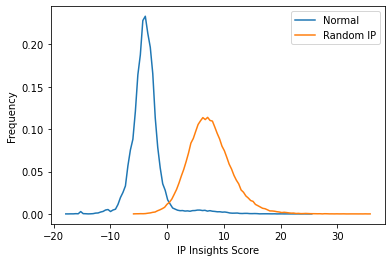

<Figure size 432x288 with 0 Axes>

In [44]:
n, x = np.histogram(test_case_scores[:NUM_SAMPLES], bins=100, density=True)
plt.plot(x[1:], n)

n, x = np.histogram(test_case_scores[NUM_SAMPLES:], bins=100, density=True)
plt.plot(x[1:], n)

plt.legend(["Normal", "Random IP"])
plt.xlabel("IP Insights Score")
plt.ylabel("Frequency")

plt.figure()

###### [4] Selecting a Good Threshold

As we see in the figure above, there is a clear separation between normal traffic and random traffic. We could select a threshold depending on the application.

- If we were working with low impact decisions, such as whether to ask for another factor or authentication during login, we could use a threshold = 0.0. This would result in catching more true-positives, at the cost of more false-positives.

- If our decision system were more sensitive to false positives, we could choose a larger threshold, such as threshold = 10.0. That way if we were sending the flagged cases to manual investigation, we would have a higher confidence that the acitivty was suspicious.

In [45]:
threshold = 0.0

flagged_cases = test_case[np.array(test_case_scores) > threshold]

num_flagged_cases = len(flagged_cases)
num_true_positives = len(flagged_cases[flagged_cases['label'] == 1])
num_false_positives = len(flagged_cases[flagged_cases['label'] == 0])
num_all_positives = len(test_case.loc[test_case['label'] == 1])

print("When threshold is set to: {}".format(threshold))
print("Total of {} flagged cases".format(num_flagged_cases))
print("Total of {} flagged cases are true positives".format(num_true_positives))
print("True Positive Rate: {}".format(num_true_positives/float(num_flagged_cases)))
print("Recall: {}".format(num_true_positives/float(num_all_positives)))
print("Precision: {}".format(num_true_positives/float(num_flagged_cases)))

When threshold is set to: 0.0
Total of 103009 flagged cases
Total of 98256 flagged cases are true positives
True Positive Rate: 0.953858400722267
Recall: 0.98256
Precision: 0.953858400722267


### (optional) 10. Compute Anomaly Scores based on Test set

SageMaker algorithms come with support for two additional services that make optimizing and using the algorithm that much easier: **Automatic Model Tuning** and **Batch Transform**

#### (1) Automatic Model Tuning
The results above were based on using the default hyperparameters of the SageMaker IP Insights algorithm. If we wanted to improve the model's performance even more, we can use Amazon SageMaker Automatic Model Tuning to automate the process of finding the hyperparameters.

**Validation Dataset**
Previously, we separated our dataset into a training and test set to validate the performance of a single IP Insights model. However, when we do model tuning, we train many IP Insights models in parallel. If we were to use the same test dataset to select the best model, we bias our model selection such that we don't know if we selected the best model in general, or just the best model for that particular dateaset.

Therefore, we need to separate our test set into a validation dataset and a test dataset. The validation dataset is used for model selection. Then once we pick the model with the best performance, we evaluate it the winner on a test set just as before.

**Validation Metrics**
For SageMaker Automatic Model Tuning to work, we need an objective metric which determines the performance of the model we want to optimize. Because SageMaker IP Insights is an usupervised algorithm, we do not have a clearly defined metric for performance (such as percentage of fraudulent events discovered).

We allow the user to provide a validation set of sample data (same format as training data bove) through the validation channel. We then fix the negative sampling strategy to use random_negative_sampling_rate=1 and shuffled_negative_sampling_rate=0 and generate a validation dataset by assigning corresponding labels to the real and simulated data. We then calculate the model's descriminator_auc metric. We do this by taking the model's predicted labels and the 'true' simulated labels and compute the Area Under ROC Curve (AUC) on the model's performance.

In [46]:
test_df['timestamp'].describe()

count                  950187
unique                 252567
top       2018-11-13 05:50:21
freq                       16
first     2018-11-11 00:00:01
last      2018-11-14 00:00:00
Name: timestamp, dtype: object

The test set we constructed above spans 3 days. We reserve the first day as the validation set and the subsequent two days for the test set.

In [47]:
time_partition = datetime(2018, 11, 13, tzinfo=pytz.FixedOffset(0)) if num_time_zones > 1 else datetime(2018, 11, 13)

validation_df = test_df[test_df['timestamp'] < time_partition]
test_df = test_df[test_df['timestamp'] >= time_partition]

valid_data = validation_df.to_csv(index=False, header=False, columns=['user', 'ip_address'])

In [48]:
# Upload validation to S3
validation_data_file = 'valid.csv'
key = os.path.join(prefix, 'validation', validation_data_file)
boto3.resource('s3').Bucket(bucket).Object(key).put(Body=valid_data)
s3_valid_data = 's3://{}/{}'.format(bucket, key)

print('Validation data has been uploaded to: {}'.format(s3_valid_data))

# Configure SageMaker IP Insights Input Channels
input_data = {
    'train': s3_train_data,
    'validation': s3_valid_data
}

Validation data has been uploaded to: s3://sagemaker-us-west-2-570447867175/ip-insights\validation\valid.csv


In [54]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

# Configure HyperparameterTuner
ip_insights_tuner = HyperparameterTuner(
    estimator=ip_insights,  # previously-configured Estimator object #
    objective_metric_name='validation:discriminator_auc',
    hyperparameter_ranges={'vector_dim': IntegerParameter(64, 1024)},
    max_jobs=2,
    max_parallel_jobs=4)

# Start hyperparameter tuning job
ip_insights_tuner.fit(input_data, include_cls_metadata=False)

In [55]:
# Wait for all the jobs to finish
ip_insights_tuner.wait()

# Visualize training job results
ip_insights_tuner.analytics().dataframe()

..............................................................................................................................................................................................................................................!


,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,398.0,ipinsights-200712-1633-001-880df896,Completed,0.990466,2020-07-12 16:35:45-07:00,2020-07-12 16:52:47-07:00,1022.0


In [56]:
# Deploy best model
tuned_predictor = ip_insights_tuner.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge',
    content_type='text/csv',
    serializer=csv_serializer,
    accept='application/json',
    deserializer=json_deserializer
)

2020-07-12 23:52:47 Starting - Preparing the instances for training
2020-07-12 23:52:47 Downloading - Downloading input data
2020-07-12 23:52:47 Training - Training image download completed. Training in progress.
2020-07-12 23:52:47 Uploading - Uploading generated training model
2020-07-12 23:52:47 Completed - Training job completed

Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2020 23:37:10 INFO 140204685006656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'random_negative_sampling_rate': u'1', u'shuffled_negative_sampling_rate': u'1', u'batch_metrics_publish_interval': u'1000', u'num_entity_vectors': u'100000', u'_tuning_objective_metric': u'', u'vector_dim': u'128', u'learning_rate': u'0.001', u'epochs': u'10', u'_num_gpus': u'auto', u'weight_decay': u'0.00001', u'_kvstore': u'auto_gpu', u'_num_kv_servers': u'auto', u'mini_batch_size': u'5000', u'_log_level': u'info', u'num_ip_encoder_layers': u'1'}
[07/12/2020 23:37:10 INFO 140204685006656] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'random_negative_sampling_rate': u'5', u'num_entity_vectors': u'20000', u'_tuning_objective_metric': u'validation:discriminator_auc', u'vector_dim': u'398', u'learn

In [57]:
# Make a prediction 
tuned_predictor.predict(inference_data)

{'predictions': [{'dot_product': 4.44974422454834},
  {'dot_product': 3.997523069381714},
  {'dot_product': 3.1688296794891357},
  {'dot_product': 4.983971118927002},
  {'dot_product': 6.965197563171387}]}

In [ ]:
# sess.delete_endpoint(tuned_predictor.endpoint)

##### Now we can determine thresholds and make predictions just like we did with the inference endpoint

#### (2) Batch Transform
Let's say we want to score all of the login events at the end of the day and aggregate flagged cases for investigators to look at in the morning. If we store the daily login events in S3, we can use IP Insights with Amazon SageMaker Batch Transform to run inference and store the IP Insights scores back in S3 for future analysis.

Below, we take the training job from before and evaluate it on the validation data we put in S3.

In [58]:
transformer = ip_insights.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
)

transformer.transform(
    s3_valid_data,
    content_type='text/csv',
    split_type='Line'
)

In [59]:
# Wait for Transform Job to finish
transformer.wait()

.........................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[07/13/2020 00:24:09 INFO 140096139585344] loaded entry point class algorithm.serve.server_config:config_api
[07/13/2020 00:24:09 INFO 140096139585344] loading entry points
[07/13/2020 00:24:09 INFO 140096139585344] loaded request iterator text/csv
[07/13/2020 00:24:09 INFO 140096139585344] Loaded iterator creator application/x-ndarray for content type ('application/x-ndarray', '1.0')
[07/13/2020 00:24:09 INFO 140096139585344] Loaded iterator creator text/csv for content type ('text/csv', '1.0')
[07/13/2020 00:24:09 INFO 140096139585344] loaded request iterator application/json
[07/13/2020 00:24:09 INFO 140096139585344] loaded request iterator application/jsonlines
[07/13/2020 00:24:09 INFO 140096139585344] loaded response encoder application/json
[07/13/2020 00:24:09 INFO 140096139585344] loaded response encoder application/jsonlines
[07/13/2020 00:24:10 INFO 1400

In [60]:
print("Batch Transform output is at: {}".format(transformer.output_path))

Batch Transform output is at: s3://sagemaker-us-west-2-570447867175/ipinsights-2020-07-13-00-19-59-019


### 11. Close the SageMaker Instance

In [62]:
ip_insights_tuner.delete_endpoint()

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

In [ ]:
#########################################################

Reference
>https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights.html